In [1]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
from skimage.segmentation import find_boundaries
import xesmf as xe
import dask.array as da
import scipy
from dask.distributed import progress
import pyproj
import warnings
import healpy as hp
import easygems.healpix as egh
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import glob
from dask.distributed import Client

In [2]:
import os
import sys

user_id = os.environ['USER']
sys.path.append(f'/home/548/{user_id}/working/hk25-AusNode-coastal/')

In [3]:
from sea_breeze_code.utils import get_nn_lon_lat_index
from sea_breeze_code.load_model_data import get_coastline_angle_kernel
from sea_breeze_code.sea_breeze_funcs import rotate_wind

In [4]:
client = Client()

2025-05-14 13:41:00,730 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-sftlf-4bab32364036a3fc118bfd8cfa90f706' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x1464a7b42170>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x146430f85240>, key=BasicIndexer((slice(None, None, None),))), func=functools.partial(<function _apply_mask at 0x1464c7a2c3a0>, encoded_fill_values={0.0}, decoded_fill_value=nan, dtype=dty

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43853,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:38663,Total threads: 2
Dashboard: /proxy/42069/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:34041,


In [8]:
#Open some sample data
ds = xr.open_zarr("/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z8_atm.zarr/")

In [9]:
ds

<xarray.Dataset> Size: 225GB
Dimensions:  (crs: 1, cell: 786432, time: 10200)
Coordinates:
  * crs      (crs) float32 4B nan
  * time     (time) datetime64[ns] 82kB 2020-01-01T01:00:00 ... 2021-03-01
Dimensions without coordinates: cell
Data variables:
    orog     (cell) float32 3MB dask.array<chunksize=(786432,), meta=np.ndarray>
    pr       (time, cell) float32 32GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    psl      (time, cell) float32 32GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    rlut     (time, cell) float32 32GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    rsut     (time, cell) float32 32GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    sftgif   (cell) float32 3MB dask.array<chunksize=(786432,), meta=np.ndarray>
    sftlf    (cell) float32 3MB dask.array<chunksize=(786432,), meta=np.ndarray>
    ts       (time, cell) float32 32GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    uas      (time, cell) float32 32GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    vas      (time, cell) float32 32GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
Attributes:
    hiopy::parent:  PT1H_point_z9_atm

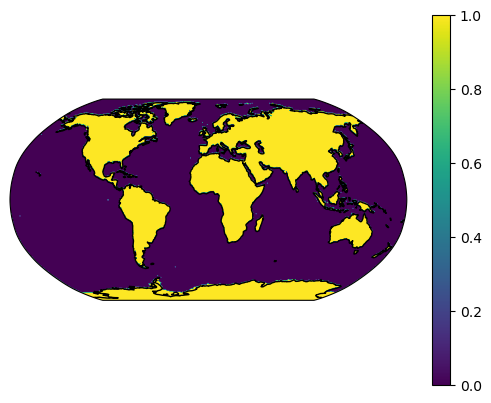

In [10]:
#Plot the healpix grid land sea mask
ax=plt.axes(projection=ccrs.Robinson(central_longitude=0))
ax.set_global()
im = egh.healpix_show(ds.sftlf>=0.5,ax=ax)
ax.coastlines()
plt.colorbar(im)

In [11]:
#Get the "nside", which is used for regridding
nside = hp.get_nside(ds.uas)

In [12]:
#Set up target latitude and longitude (regular grid) to interpolate onto
target_lats = np.linspace(
    -90,
    90,
    int(np.round(np.sqrt(ds.cell.shape[0])))
)
target_lons = np.linspace(
    0,
    360,
    int(np.round(np.sqrt(ds.cell.shape[0])))
)

#Do the interpolation and return the healpix cell indices
target_inds = get_nn_lon_lat_index(nside, target_lons, target_lats)

#Define the regridded land sea mask
lsm = ((ds.sftlf.isel(cell=target_inds))>0.5).persist()

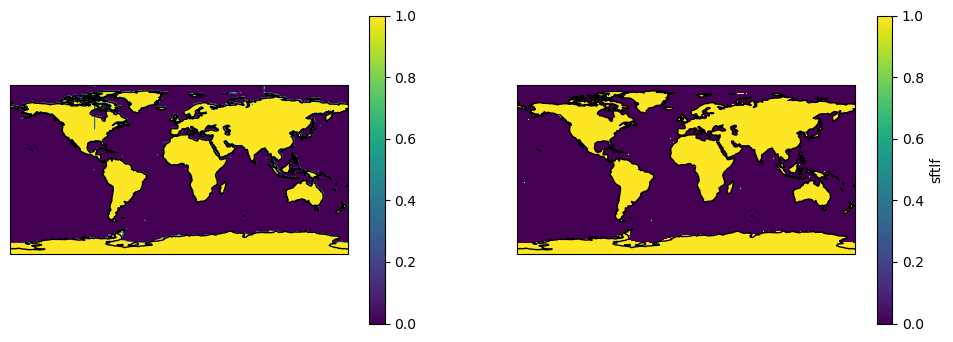

In [13]:
#Compare the healpix land sea mask with the regridded land sea mask

plt.figure(figsize=[12,4])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree(central_longitude = 0.0))
ax.set_global()
im = egh.healpix_show(ds.sftlf>=0.5,ax=ax)
ax.coastlines()
plt.colorbar(im)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
im=((ds.sftlf.isel(cell=target_inds))>0.5).plot(ax=ax, transform = ccrs.PlateCarree())
ax.coastlines()

In [ ]:
#From the land sea mask, define dominant coastline angles through the whole domain.
#R specifies the smoothing of nearby points, in the inverse distance weighting function (see get_weights())
angle_ds = get_coastline_angle_kernel(lsm,R=100,latlon_chunk_size=10)    

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...
INFO: Calculating the sum of the weights...
INFO: Calculating variance...
INFO: Calculating minimum distance to the coast...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
 

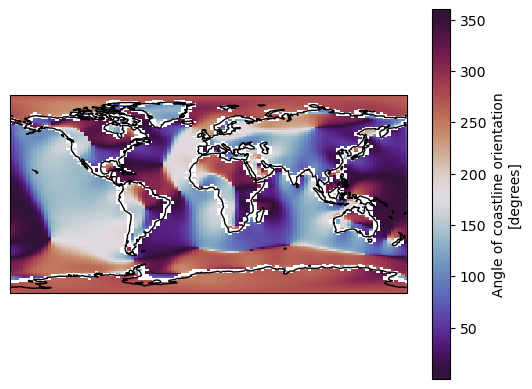

In [21]:
#Plot the coastline angles
ax=plt.axes(projection=ccrs.PlateCarree())
im=angle_ds.angle.plot(ax=ax, transform = ccrs.PlateCarree(), cmap="twilight_shifted")
ax.coastlines()

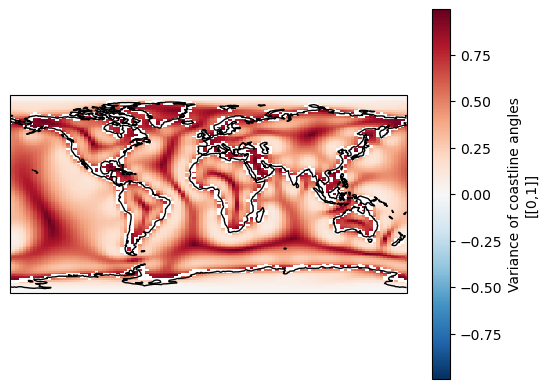

In [22]:
#Plot the coastline variance
ax=plt.axes(projection=ccrs.PlateCarree())
im=angle_ds.variance.plot(ax=ax, transform = ccrs.PlateCarree())
ax.coastlines()

In [24]:
#Code from Zhe Feng || zhe.feng@pnnl.gov
#https://github.com/digital-earths-global-hackathon/hk25-teams/blob/main/hk25-MCS/remap_mcsmask_to_healpix_fullglobe.ipynb

#To re-map to healpix format

ds = ds.pipe(partial(egh.attach_coords))
lon_hp = ds.lon.assign_coords(cell=ds.cell, lon_hp=lambda da: da)
lat_hp = ds.lat.assign_coords(cell=ds.cell, lat_hp=lambda da: da)

angle_ds_hp = angle_ds.sel(lon=lon_hp, lat=lat_hp, method="nearest")
angle_ds_hp = angle_ds_hp.drop_vars(["lat_hp", "lon_hp"])


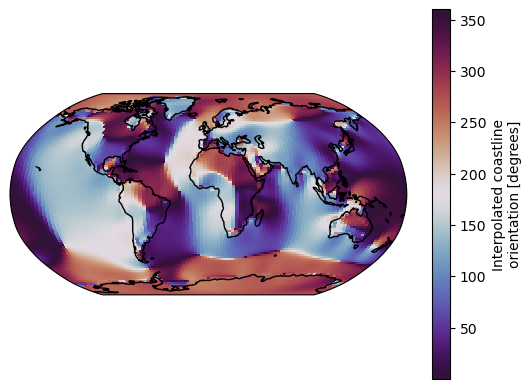

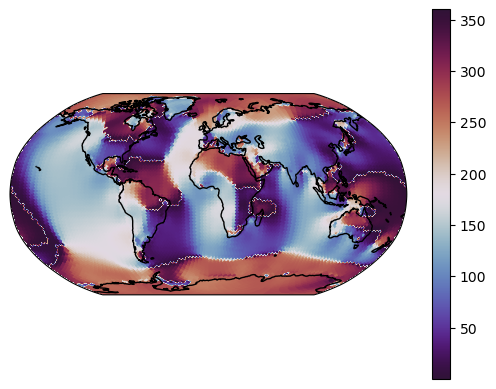

In [32]:
#Compare lat-lon regridded angles with the angles converted back to healpix

plt.figure()
ax=plt.axes(projection=ccrs.Robinson(central_longitude=0))
angle_ds.angle_interp.plot(cmap="twilight_shifted",transform=ccrs.PlateCarree())
ax.coastlines()

plt.figure()
ax=plt.axes(projection=ccrs.Robinson(central_longitude=0))
ax.set_global()
im = egh.healpix_show(angle_ds_hp.angle_interp,ax=ax,cmap="twilight_shifted")
ax.coastlines()
plt.colorbar(im)


In [33]:
#Rotate the U and V winds to coast relative (vprime is towards the coast)
uprime,vprime=rotate_wind(ds.uas,ds.vas,angle_ds_hp.angle_interp)


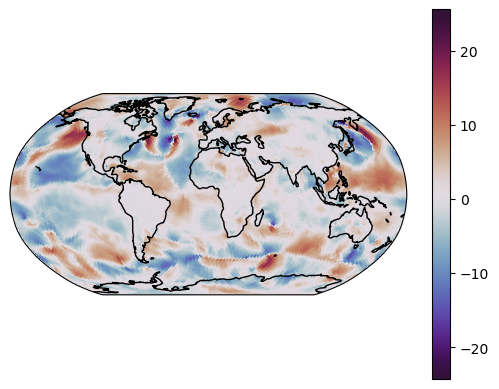

In [29]:
#Plot vprime for a single time step

plt.figure()
ax=plt.axes(projection=ccrs.Robinson(central_longitude=0))
ax.set_global()
im = egh.healpix_show(vprime.isel(time=0),ax=ax,cmap="twilight_shifted")
ax.coastlines()
plt.colorbar(im)

In [31]:
#Save the healpix angles to disk
angle_ds_hp.to_zarr("/scratch/ng72/ab4502/tmp/icon_z5.zarr")

In [13]:
#Regrid the u and v winds in the same way as the land-sea mask
#Just for one time step
uas_regrid = ds.uas.isel(time=0,cell=target_inds).sel(lat=slice(-15,10),lon=slice(90,170))
vas_regrid = ds.vas.isel(time=0,cell=target_inds).sel(lat=slice(-15,10),lon=slice(90,170))

In [14]:
#Rotate these winds to find the component perpendicular to the coastline (vprime)
_,vprime = rotate_wind(uas_regrid,vas_regrid,angle_ds.angle_interp)

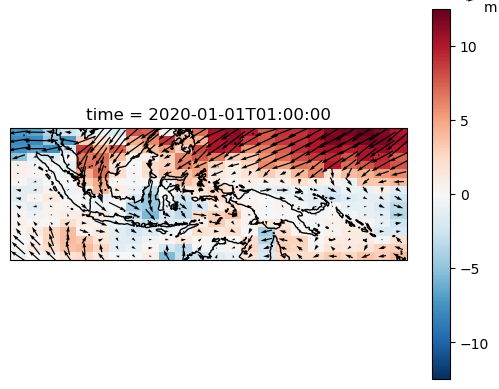

In [15]:
#Plot vprime and associated wind vectors for the first model time step
ax=plt.axes(projection=ccrs.PlateCarree())
im=vprime.plot(ax=ax, transform = ccrs.PlateCarree())
xr.Dataset(
    {"u":uas_regrid,
    "v":vas_regrid}).plot.quiver(
    x="lon",
    y="lat",
    u="u",
    v="v")
ax.coastlines()

In [25]:
#Now regrid u wind for all time steps. This takes a while
uas_regrid = ds.uas.isel(cell=target_inds)

In [28]:
#Same for v wind
vas_regrid = ds.vas.isel(cell=target_inds)

In [30]:
#Calculate the cross-coast wind component
_,vprime = rotate_wind(uas_regrid,vas_regrid,angle_ds.angle_interp)

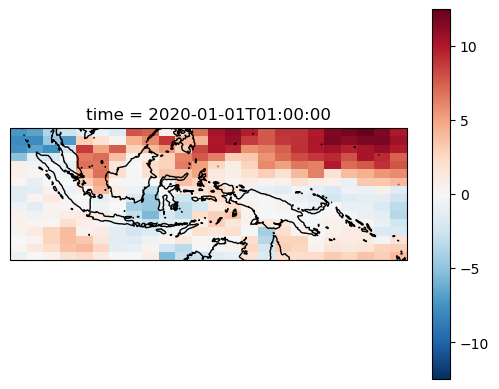

In [35]:
ax=plt.axes(projection=ccrs.PlateCarree())
vprime.sel(lat=slice(-15,10),lon=slice(90,170)).isel(time=0).plot()
ax.coastlines()

In [45]:
hourly_mean_vprime = vprime.sel(lat=slice(-15,10),lon=slice(90,170)).groupby("time.hour").mean().persist()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


In [ ]:
cnt=1
plt.figure(figsize=[16,10])
for hour in [0,6,12,18]:

    ax=plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())
    hourly_mean_vprime.sel(hour=hour).plot(cbar_kwargs={"label":"Onshore wind component (m/s)"})
    #ax.coastlines()
    xr.plot.contour(lsm.sel(lat=slice(-15,10),lon=slice(90,170)),colors=["k"],linewidths=1,levels=[0.5])
    ax.gridlines(ls=":",draw_labels=["left","bottom"])
    plt.title("Hour="+str(hour)+" UTC")
    cnt=cnt+1

Text(0.5, 0, 'Hour (UTC)')

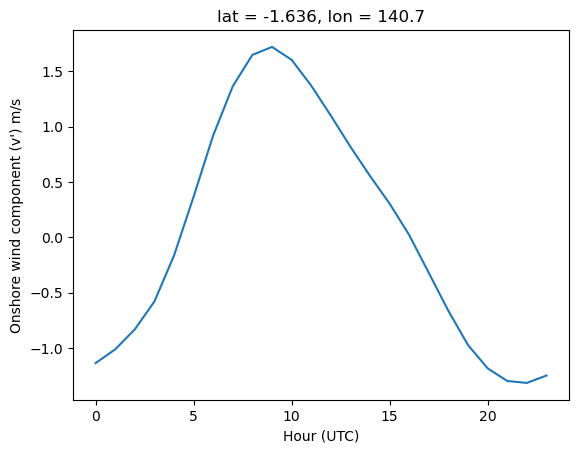

In [69]:
hourly_mean_vprime.sel(lat=-2,lon=140,method="nearest").plot()
plt.ylabel("Onshore wind component (v') m/s")
plt.xlabel("Hour (UTC)")